In [14]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from Environment import SpringMass
from Subroutines import ModelEstV2,ApproxDAP,max_norm,find_stable_radius,SafeTransit
from time import time
from Controllers import SafeDAP
from scipy.linalg import sqrtm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Find a highly stable spring-mass system

Spectral radius of A: 0.8516025637391125 2.3765475336339104 2.9853854876930965
Step 0
Step 100
Step 0
Step 100


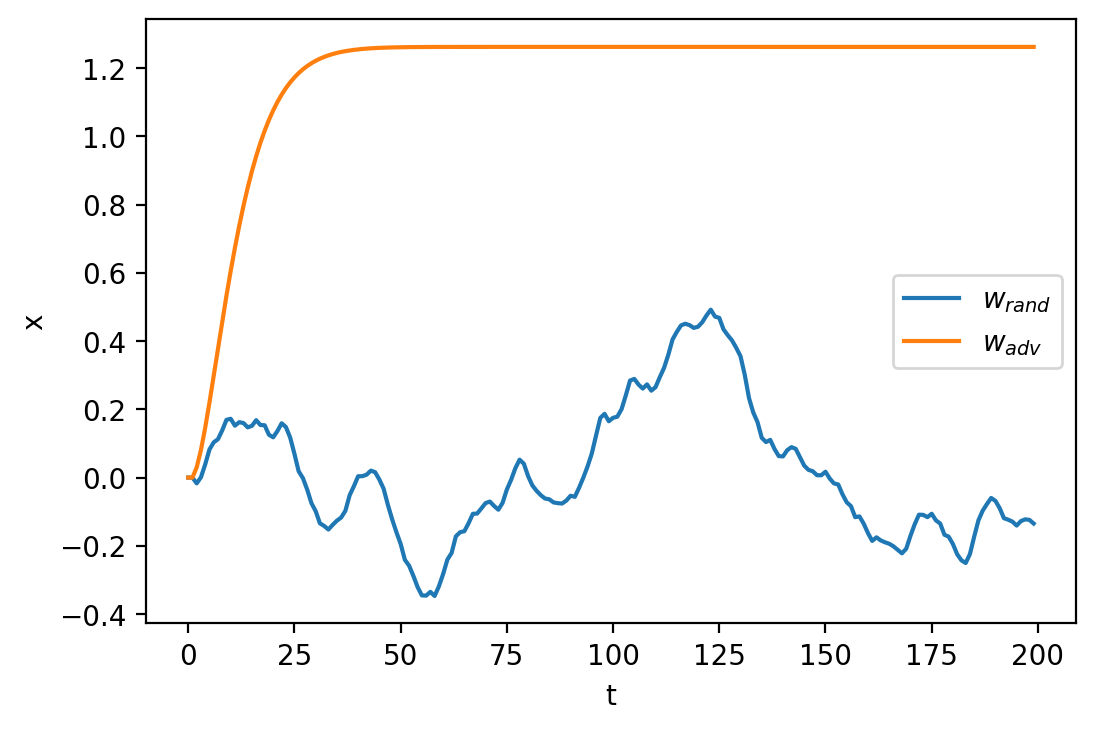

In [15]:
def evaluate(space_dim,dt,K_m_dt,l_m_dt):
    O = np.zeros((space_dim,space_dim))
    I = np.eye(space_dim)

    A = np.vstack([np.hstack([O,dt*I]),
                   np.hstack([-K_m_dt*I,-l_m_dt*I])]) + np.eye(2*space_dim)

    return  np.max(np.abs(np.linalg.eigvals(A)))

dt = 0.1
space_dim = 1
m = 1

candidate_param = np.random.rand(1000,2) * 0.3
istar = np.argmin([evaluate(space_dim,dt,K_m_dt,l_m_dt) for (K_m_dt,l_m_dt) in candidate_param])

K_star, l_star = candidate_param[istar]


K_star,l_star

K = K_star * m/dt

l = l_star*m/dt

print('Spectral radius of A:',evaluate(space_dim,dt,K_star,l_star),K,l)

x_0 = np.array([0,0]).reshape(-1,1)
time_steps = 200

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0)


x_rand_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_rand_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)


x_adv_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_adv_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)


# plt.plot(np.array(x_hist)[:,0],label='SafeDAP')
plt.figure(dpi=200)
plt.plot(np.array(x_rand_disturbance)[:,0],label=r'$w_{rand}$')
plt.plot(np.array(x_adv_disturbance)[:,0],label=r'$w_{adv}$')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

# Safe Adaptive Control

In [16]:

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l)
A = env.A
B = env.B
# Find a region(B(A,eps_init)) around A and ensure it contains only stable matrices.
eps_init = find_stable_radius(A)

est = ModelEstV2(A,B,eps_init) # The model estimator.

H = 20 # Look back length

eta_bar = 0.2 # The magnitude of exploration noise.


# Constants
x_dim = A.shape[-1]
u_dim = B.shape[-1]

I_x = np.eye(x_dim)  
I_u = np.eye(u_dim)  


w_cov = np.eye(x_dim) * env.w_max * 1/12 # Assume uniform distribution.

# Inputs to SafeDAP

Q = np.array([[1,0],
                [0,1]])*1
R = np.eye(u_dim)*1

D_x = np.vstack([I_x,-I_x]) # Constraints
# d_x = np.array([0.5,0.5,0.5,0.5])
d_x = np.array([4,6.0,4,6.0])

D_u = np.vstack([I_u,-I_u])
d_u = np.array([6,6])

w_max = env.w_max 

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

M0 = np.zeros((H,u_dim,x_dim))

e_x = 0 # Usually e_x is not zero 
e_u = 0 # For safe DAP with known B, e_u = 0

n_episode = 5
refit_per_step = 50
pre_run_steps = 2
TD_steps  = 30 # The least number of steps taken in Phase 1.


x_hist = []
u_hist = []
w_hat_hist = [np.zeros((x_dim,1)) for _ in range(10*H)]

theta_hist = []
refit_time_step = []
phase1_endpoints =[]
phase2_endpoints=[]
M_hist = [M0]
r_hist = []

def phase(A_hat,B_hat,old_eta,new_eta):
    # Local variables: A_hat,B_hat,old,new.
    # Global variables: theta_hist,M_hist,e_x,e_u,H,env,w_max, w_hat_hist
    # Start of the phase
    # Solve for new controller M.
    M,Phi = safeDapSolver.solve(A_hat,B_hat,H,e_x=e_x,e_u=e_u)

    if _==1:
         old = {'M':np.array(M),'theta':(np.array(A_hat),np.array(B_hat)),'eta':old_eta,'r':r_hist[-1]}
    else:
        old = {'M':np.array(M_hist[-1]),'theta':theta_hist[-2],'eta':old_eta,'r':r_hist[-2]}
    new = {'M':np.array(M),'theta':theta_hist[-1],'eta':new_eta,'r':r_hist[-1]}

    old['e_x']=new['e_x']=e_x
    old['e_u']=new['e_u']=e_u

    M_hist.append(np.array(M))

    # Compute mid.
    mid = safeDapSolver.mid(old,new,H)

    transit = SafeTransit(old,new,mid,H)

    for i in range(refit_per_step):
        x = env.state()
        u = transit.get_u(w_hat_hist)
        env.step(u)

        Ah,Bh = transit.get_theta()
        # Calculate the estimated disturbance, and project it onto the bounded disturbance set. 
        w_hat = env.state()-Ah.dot(x)-Bh.dot(u)
        w_hat[w_hat>w_max] = w_max
        w_hat[w_hat<-w_max] = -w_max 
        w_hat_hist.append(np.array(w_hat)) 

        u_hist.append(u)
        x_hist.append(x)

        # Updating M in the transit object.
        transit.step()
    # End of the phase

# main loop
for _ in range(n_episode):

    if _==0:
        for i in range(pre_run_steps):
            x = env.state()
            x_hist.append(x)
            u = (np.random.rand()-0.5)*2*eta_bar
            env.step(u)
            u_hist.append(u)
        A_hat,B_hat,r = est.est(np.array(x_hist).reshape(-1,x_dim),np.array(u_hist[:-1]).reshape(-1,u_dim))
        theta_hist.append((np.array(A_hat),np.array(B_hat)))
        r_hist.append(float(r))
        refit_time_step.append(len(x_hist))
        print(A_hat,B_hat)

        # Fit the system parameters for the first time.
    else:

        M,Phi = safeDapSolver.solve(A_hat,B_hat,H,e_x=e_x,e_u=e_u)
        M_hist.append(np.array(M))

        # Phase 1: exploration exploitation 

        print('phase 1')
        phase(A_hat,B_hat,0,eta_bar)

        phase1_endpoints.append(len(x_hist))

        # Refit the system model
        A_hat,B_hat,r = est.est(np.array(x_hist).reshape(-1,x_dim),np.array(u_hist[:-1]).reshape(-1,u_dim))
        theta_hist.append((np.array(A_hat),np.array(B_hat)))
        r_hist.append(float(r))
        refit_time_step.append(len(x_hist))

        # Phase 2: pure exploitation 
        print('phase 2')
        phase(A_hat,B_hat,eta_bar,0)

        phase2_endpoints.append(len(x_hist))


        print('Episode',_)



0.9691871857838912
[[ 0.95557987  0.09555799]
 [-0.2270981   0.67030244]] [[0.        ]
 [0.15545455]]
phase 1
phase 2
Episode 1
phase 1
phase 2
Episode 2
phase 1
phase 2
Episode 3
phase 1
phase 2
Episode 4


# Open loop evolution of the system(no control)

In [17]:
env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

x_no_control_hist = []
# main loop
for _ in range(len(x_hist)):
    x = env.state()
    u = 0 
    env.step(u)
    
    x_no_control_hist.append(x)
    
    if _%100 == 0:
        print('Step',_)

Step 0
Step 100
Step 200
Step 300
Step 400


# Safe Control(with perfect knowledge about the underlying system) 

In [18]:
env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)
u_dim=1
Q = np.array([[1,0],
            [0,1]])*1
R = np.eye(u_dim)*1

D_x = np.vstack([I_x,-I_x]) # Constraints
# d_x = np.array([0.5,0.5,0.5,0.5])
d_x = np.array([4,6.0,4,6.0])

D_u = np.vstack([I_u,-I_u])
d_u = np.array([6,6])

safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

e_x = 0 # Usually e_x is not zero 
e_u = 0 # For safe DAP with known B, e_u = 0
# # Pre-run steps 

x_true_hist = []
u_true_hist = []
w_true_hist = [np.zeros((x_dim,1)) for _ in range(10*H)]
time_steps = 400

pre_run_steps = 0

# M,Phi = safeDapSolver.solve(A_final,B,H,e_x=e_x,e_u=e_u)
M,Phi = safeDapSolver.solve(A,B,H,e_x=e_x,e_u=e_u)
# M,Phi = safeDapSolver.solve(theta_hist[-1][0],theta_hist[-1][1],H,e_x=e_x,e_u=e_u)
     
# main loop
for _ in range(len(x_hist)):
    x = env.state()
    x_true_hist.append(x)
    if _<pre_run_steps:
        u = (np.random.rand()-0.5)*2*eta_bar
    else:
        u = ApproxDAP(M,w_true_hist,eta_bar)

    env.step(u)
    u_true_hist.append(u)
    
    w_true_hist.append(env.state()-A.dot(x_true_hist[-1])-B.dot(u_true_hist[-1]))
    
    if _%100 == 0:
        print('Step',_)

Step 0
Step 100
Step 200
Step 300
Step 400


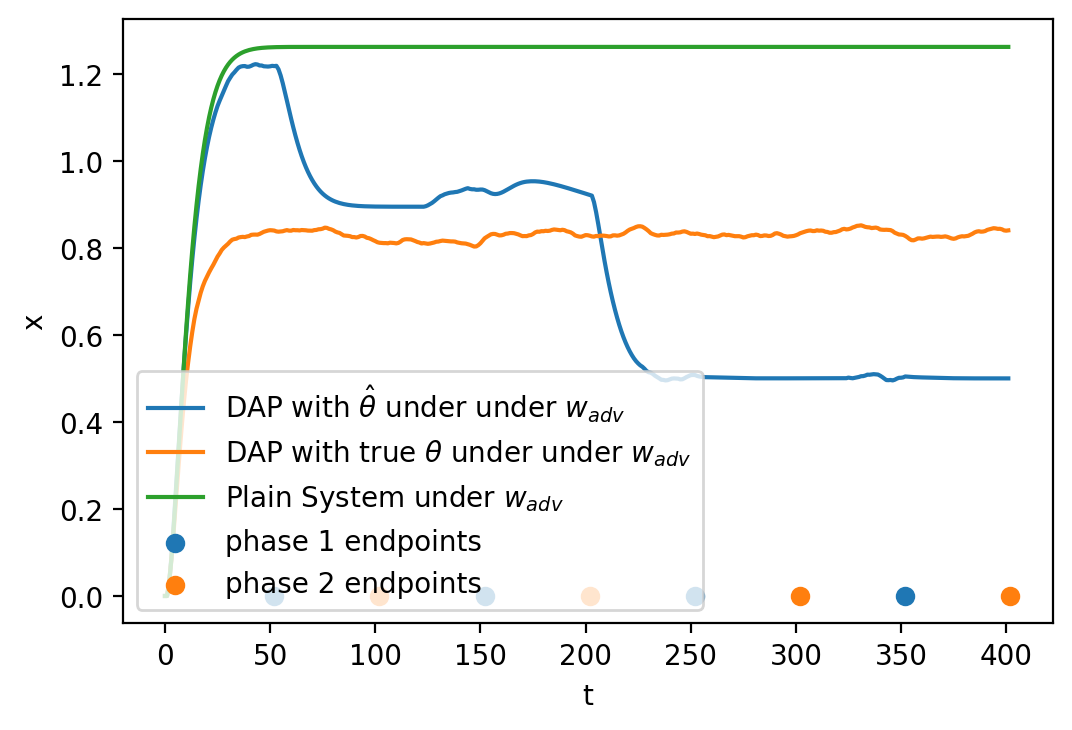

In [19]:
plt.figure(dpi=200)
plt.plot(np.array(x_hist)[:,0],label=r'DAP with $\hat{\theta}$ under under $w_{adv}$')
plt.plot(np.array(x_true_hist)[:,0],label=r'DAP with true $\theta$ under under $w_{adv}$')

plt.plot(np.array(x_no_control_hist)[:,0],label=r'Plain System under $w_{adv}$')

plt.scatter(phase1_endpoints,np.zeros(len(phase1_endpoints)),label='phase 1 endpoints')
plt.scatter(phase2_endpoints,np.zeros(len(phase2_endpoints)),label='phase 2 endpoints')


plt.xlabel('t')


plt.ylabel('x')
plt.legend()


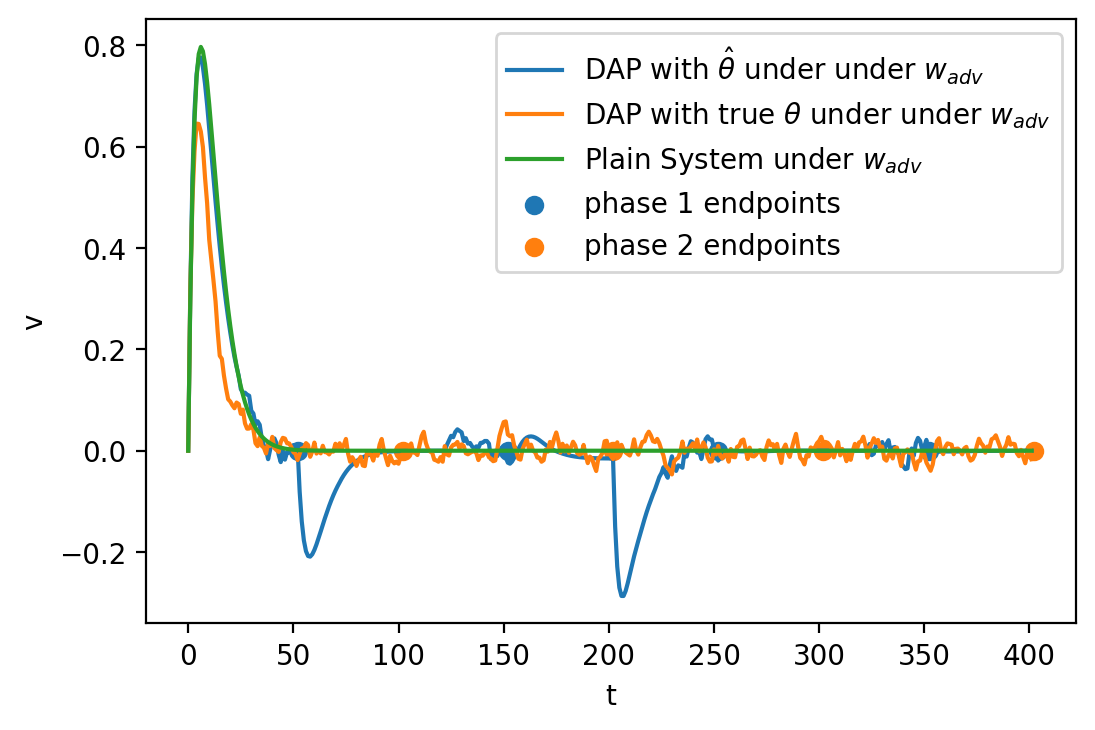

In [20]:
plt.figure(dpi=200)
plt.plot(np.array(x_hist)[:,1],label=r'DAP with $\hat{\theta}$ under under $w_{adv}$')
plt.plot(np.array(x_true_hist)[:,1],label=r'DAP with true $\theta$ under under $w_{adv}$')

plt.plot(np.array(x_no_control_hist)[:,1],label=r'Plain System under $w_{adv}$')

plt.scatter(phase1_endpoints,np.zeros(len(phase1_endpoints)),label='phase 1 endpoints')
plt.scatter(phase2_endpoints,np.zeros(len(phase2_endpoints)),label='phase 2 endpoints')


plt.xlabel('t')


plt.ylabel('v')
plt.legend()


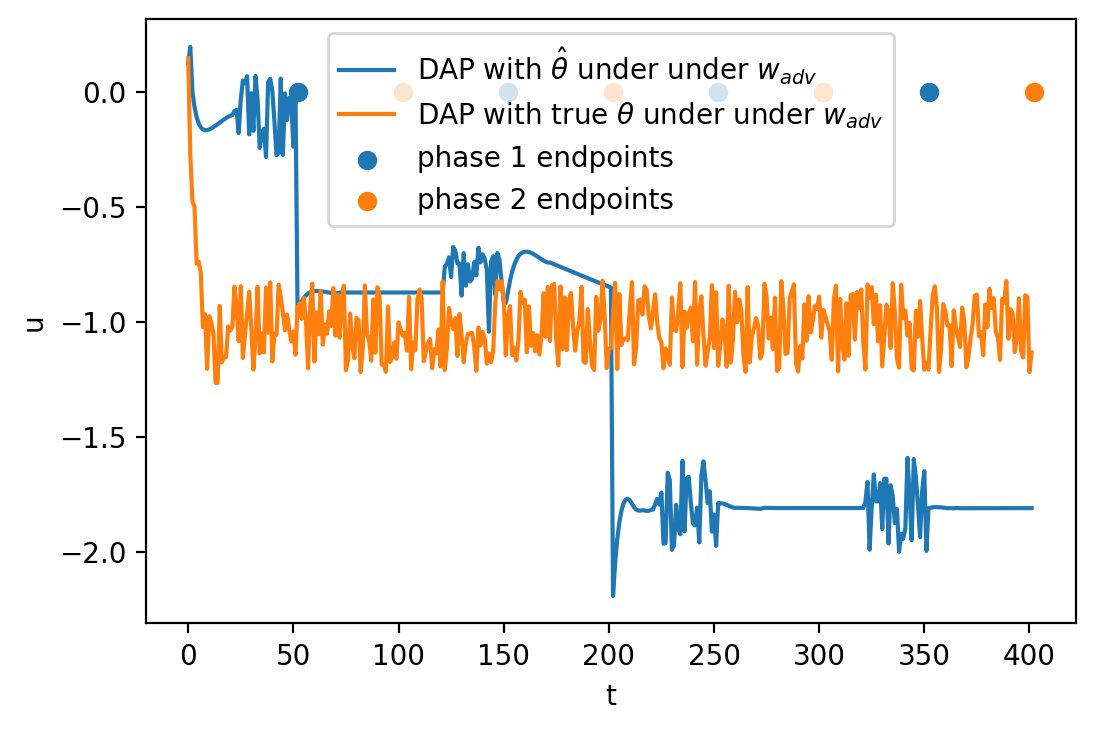

In [21]:
plt.figure(dpi=200)
plt.plot(np.array(u_hist),label=r'DAP with $\hat{\theta}$ under under $w_{adv}$')
plt.plot(np.array(u_true_hist),label=r'DAP with true $\theta$ under under $w_{adv}$')


plt.scatter(phase1_endpoints,np.zeros(len(phase1_endpoints)),label='phase 1 endpoints')
plt.scatter(phase2_endpoints,np.zeros(len(phase2_endpoints)),label='phase 2 endpoints')


plt.xlabel('t')


plt.ylabel('u')
plt.legend()


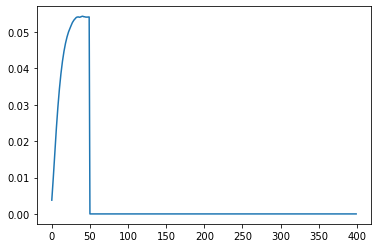

In [22]:
plt.plot(np.array(w_hat_hist[10*H:]).reshape(-1,2)[:,0])

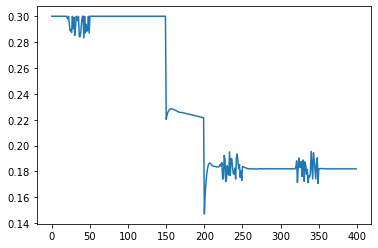

In [23]:
plt.plot(np.array(w_hat_hist[10*H:]).reshape(-1,2)[:,1])

Text(0.5, 0, '$t$')

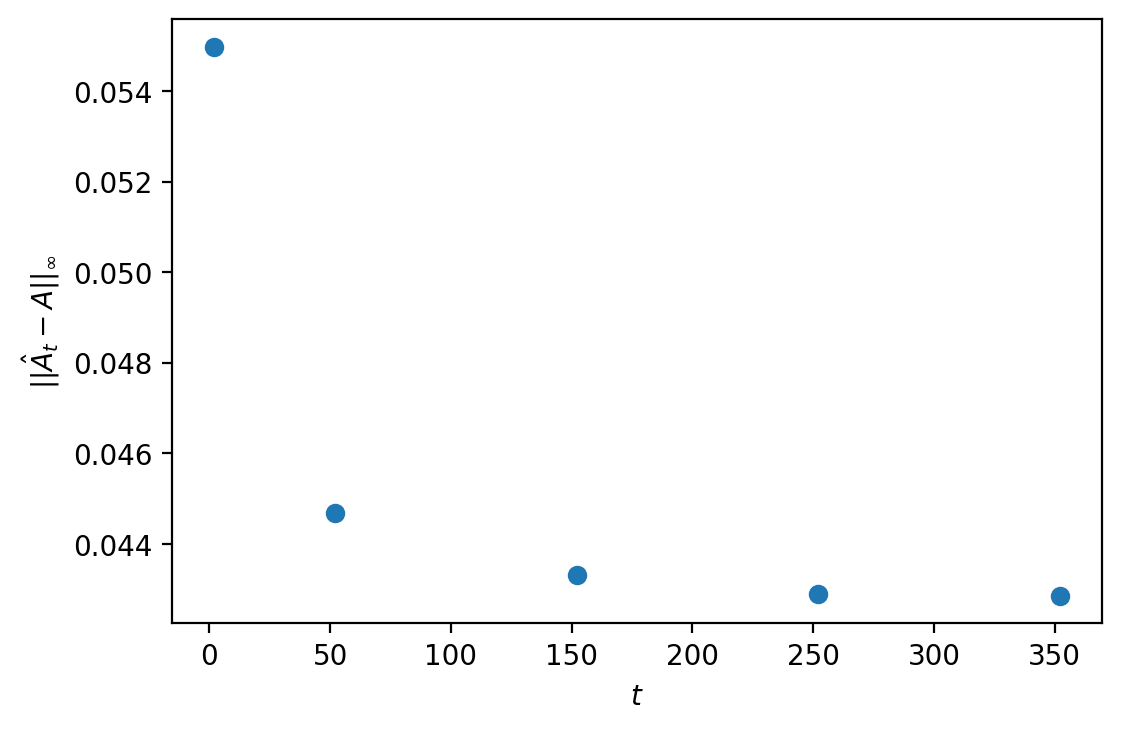

In [24]:
A_hist = np.array([m[0] for m in theta_hist])
A_diff = np.linalg.norm(A-A_hist,np.inf,axis=(-1,-2))

plt.figure(dpi=200)
plt.scatter(refit_time_step,A_diff)
plt.ylabel(r'$||\hat{A}_t-A||_{\infty}$')
plt.xlabel(r'$t$')

Text(0.5, 0, '$t$')

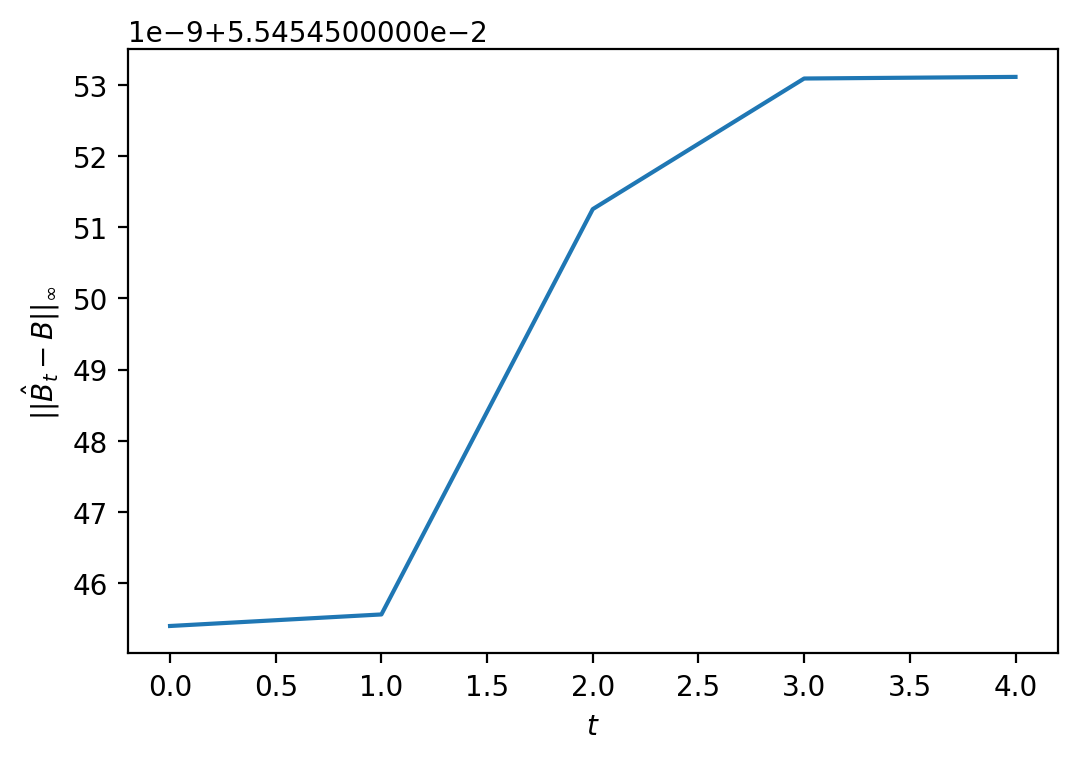

In [25]:
B_hist = np.array([m[1] for m in theta_hist])
B_diff = np.linalg.norm(B-B_hist,np.inf,axis=(-1,-2))

plt.figure(dpi=200)
# plt.scatter(refit_time_step,B_diff)
plt.plot(B_diff)

# plt.ylim((0,0.1))

plt.ylabel(r'$||\hat{B}_t-B||_{\infty}$')
plt.xlabel(r'$t$')